
== ABPC area per subgroup ==
true_positive_aggregation      : mean=2.0937e-05  std=3.1790e-05  n=8
false_positive_aggregation     : mean=4.2391e-06  std=1.1890e-05  n=8
dice_aggregation               : mean=1.6720e-01  std=3.0472e-01  n=8
logit_difference_aggregation   : mean=1.9995e-05  std=3.1022e-05  n=8


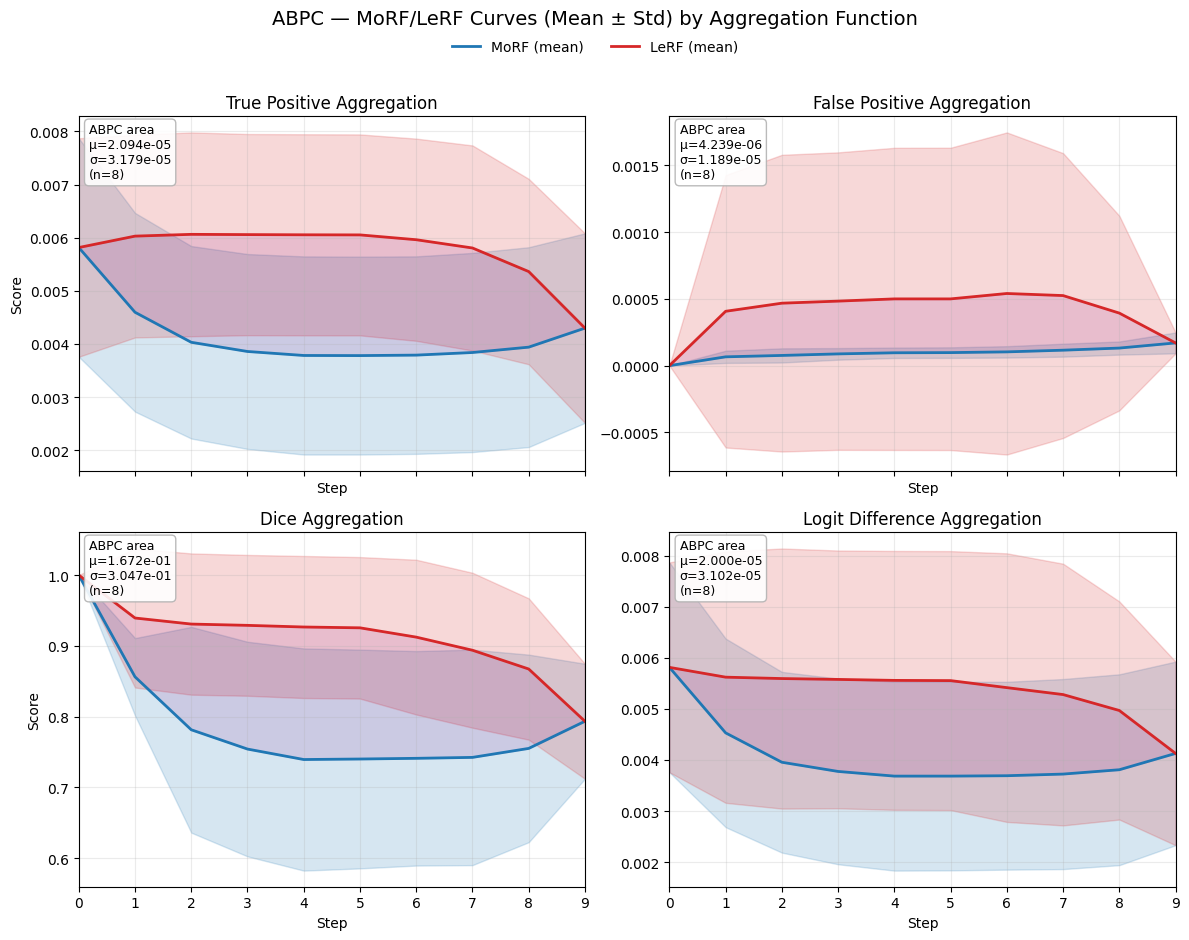

In [12]:
# matplotlib_abpc_dashboard_fast.py
# Fast dashboard for MoRF/LeRF + ABPC areas, optimized to minimize W&B API calls.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from typing import Dict, List, Tuple

# ====== CONFIG ======
ENTITY = "giuliosichili"
PROJECT = "automi"
TOP_GROUP = "ABPC"
SUBGROUPS = [
    "true_positive_aggregation",
    "false_positive_aggregation",
    "dice_aggregation",
    "logit_difference_aggregation",
]
MORF_KEY = "MoRF"
LERF_KEY = "LeRF"
ABPC_KEY = "ABPC_area"
PAGE_SIZE = 256   # scan_history page size
# Colors
MORF_COLOR = "#1f77b4"   # blue
LERF_COLOR = "#d62728"   # red
GAP_COLOR  = "purple"
BAND_ALPHA = 0.18
GAP_ALPHA  = 0.12
# =====================

def fetch_runs_fast(api: wandb.Api, entity: str, project: str) -> List[wandb.apis.public.Run]:
    """Fetch only runs in the desired top group and with one of the expected subgroups."""
    path = f"{entity}/{project}"
    filt = {
        "config.group": {"$eq": TOP_GROUP},
        "config.aggregation_function": {"$in": SUBGROUPS},
    }
    return list(api.runs(path, filters=filt))

def collect_group_data_fast(runs: List[wandb.apis.public.Run]) -> Dict[str, Dict]:
    """
    Returns:
      { subgroup: { 'curves': (n,10,2), 'abpc_values': [floats] } }
    """
    grouped: Dict[str, Dict] = {sg: {"curves": [], "abpc_values": []} for sg in SUBGROUPS}

    for r in runs:
        subgroup = (r.config or {}).get("aggregation_function")
        if subgroup not in grouped:
            continue

        # Early-stop scan: grab at most the first 10 common steps and one ABPC value
        morf_vals = {}
        lerf_vals = {}
        abpc_last = None

        # We’ll break as soon as we have 10 common steps + an ABPC value
        for row in r.scan_history(page_size=PAGE_SIZE):
            step = row.get("_step", row.get("step"))
            if step is None:
                continue

            if MORF_KEY in row and row[MORF_KEY] is not None:
                morf_vals[step] = float(row[MORF_KEY])
            if LERF_KEY in row and row[LERF_KEY] is not None:
                lerf_vals[step] = float(row[LERF_KEY])
            if ABPC_KEY in row and row[ABPC_KEY] is not None:
                abpc_last = float(row[ABPC_KEY])

            # check early-stop condition
            common = sorted(set(morf_vals.keys()) & set(lerf_vals.keys()))
            if len(common) >= 10 and (abpc_last is not None):
                break

        # Build curve if we have 10 common steps
        common = sorted(set(morf_vals.keys()) & set(lerf_vals.keys()))
        if len(common) >= 10:
            first10 = common[:10]
            morf_seq = np.array([morf_vals[s] for s in first10], dtype=float)
            lerf_seq = np.array([lerf_vals[s] for s in first10], dtype=float)
            grouped[subgroup]["curves"].append(np.stack([morf_seq, lerf_seq], axis=1))  # (10,2)

        # Keep ABPC if found
        if abpc_last is not None:
            grouped[subgroup]["abpc_values"].append(abpc_last)

    # Stack curves per subgroup
    for sg in SUBGROUPS:
        curves = grouped[sg]["curves"]
        if curves:
            grouped[sg]["curves"] = np.stack(curves, axis=0)  # (n,10,2)
        else:
            grouped[sg]["curves"] = np.empty((0, 10, 2), dtype=float)

    return grouped

def summarize_curves(curves: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if curves.size == 0:
        return (np.zeros(10), np.zeros(10), np.zeros(10), np.zeros(10))
    morf = curves[:, :, 0]
    lerf = curves[:, :, 1]
    morf_mean = morf.mean(axis=0)
    lerf_mean = lerf.mean(axis=0)
    morf_std  = morf.std(axis=0, ddof=1) if morf.shape[0] > 1 else np.zeros_like(morf_mean)
    lerf_std  = lerf.std(axis=0, ddof=1) if lerf.shape[0] > 1 else np.zeros_like(lerf_mean)
    return morf_mean, morf_std, lerf_mean, lerf_std

def main():
    api = wandb.Api()
    runs = fetch_runs_fast(api, ENTITY, PROJECT)

    grouped = collect_group_data_fast(runs)

    # Console summary
    print("\n== ABPC area per subgroup ==")
    for sg in SUBGROUPS:
        vals = grouped[sg]["abpc_values"]
        if not vals:
            print(f"{sg:30s} : n=0")
        elif len(vals) == 1:
            print(f"{sg:30s} : mean={vals[0]:.4e} (n=1)")
        else:
            print(f"{sg:30s} : mean={np.mean(vals):.4e}  std={np.std(vals, ddof=1):.4e}  n={len(vals)}")

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=True, sharey=False)  # independent Y
    axes = axes.ravel()
    steps = np.arange(10)

    titles = {
        "true_positive_aggregation": "True Positive Aggregation",
        "false_positive_aggregation": "False Positive Aggregation",
        "dice_aggregation": "Dice Aggregation",
        "logit_difference_aggregation": "Logit Difference Aggregation",
    }

    for ax, sg in zip(axes, SUBGROUPS):
        curves = grouped[sg]["curves"]
        morf_mean, morf_std, lerf_mean, lerf_std = summarize_curves(curves)

        # std bands (colored)
        ax.fill_between(steps, morf_mean - morf_std, morf_mean + morf_std, color=MORF_COLOR, alpha=BAND_ALPHA)
        ax.fill_between(steps, lerf_mean - lerf_std, lerf_mean + lerf_std, color=LERF_COLOR, alpha=BAND_ALPHA)

        # mean lines (colored)
        ax.plot(steps, morf_mean, linewidth=2.0, color=MORF_COLOR, label="MoRF (mean)")
        ax.plot(steps, lerf_mean, linewidth=2.0, color=LERF_COLOR, label="LeRF (mean)")

        # purple gap
        gap_low  = np.minimum(morf_mean, lerf_mean)
        gap_high = np.maximum(morf_mean, lerf_mean)
        ax.fill_between(steps, gap_low, gap_high, color=GAP_COLOR, alpha=GAP_ALPHA)

        # ABPC stats box
        vals = grouped[sg]["abpc_values"]
        if vals:
            mean_abpc = np.mean(vals)
            std_abpc  = np.std(vals, ddof=1) if len(vals) > 1 else 0.0
            ax.text(0.02, 0.98, f"ABPC area\nμ={mean_abpc:.3e}\nσ={std_abpc:.3e}\n(n={len(vals)})",
                    transform=ax.transAxes, ha="left", va="top",
                    bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="0.7", alpha=0.9),
                    fontsize=9)

        ax.set_title(titles.get(sg, sg))
        ax.grid(True, alpha=0.25)
        ax.set_xlim(0, 9)
        ax.set_xlabel("Step")

    axes[0].set_ylabel("Score")
    axes[2].set_ylabel("Score")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.02))
    fig.suptitle("ABPC — MoRF/LeRF Curves (Mean ± Std) by Aggregation Function", y=1.04, fontsize=14)
    fig.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


## Save some observations about starting and ending points!

* the two curves start and end in the same point (all on and all off respectively)
* FP aggr. starts on 0, as there can't be spurious predictions for the original input with respect to itself
* Dice Aggregation starts on 1, because the baseline volume produces perfect overlapping with itself.
* TP and Logit Difference start on the same point, here 0.0059 approximately. This is because for the unperturbed volume, all the logits are in the baseline segmentation mask, so their sum is equal to the sum returned by True Positive mask.

these observation are maybe of limited interest, but they strengthen the reliability of these new defined metrics as the behavior is the one expected

## Other observations
* TP plot is very regular, in the sense that LeRF and MoRF curves are mostly simmetric around a point between them. This suggests that this notion of importance, given by preservation of predicted regions, is the most natural from a perspective that considers additivity of the parts (organs in this case) important, and also imply little feature interactions since attribution order is well respected in these plots.
* FP range, which is scaled equally to TP and Logit Difference and it's a logit sum like them, so it's comparable as unit, is very low compared to them. This shows limited spurious lymph nodes predictions, at least not close to baseline segmentation mask mass.
* Dice and LogDiff show a similar shape, and it's expected since the second is a continuous version of the first. We notice a decreasing monotonic behavior in LeRF curve, while the MoRF shows a decreasing and then increasing plot in the least important organs.
